In [1]:
import torch
import utils.data_utils
import numpy as np
import librosa
import matplotlib.pyplot as plt
import model
import soundfile
import umap

In [2]:
def load_model(ckpt):
    bwg = model.BiWaveGAN(
        slice_len=32768,
        latent_dim=ckpt['latent dim'], 
        model_size=ckpt['model size'], 
        discrim_filters=ckpt['disrim filters'],
        z_discrim_depth=ckpt['z discrim depth'],
        joint_discrim_depth=ckpt['joint discrim depth'],
        phaseshuffle_rad=ckpt['phaseshuffle rad'],
        device=device)
    bwg.G.load_state_dict(ckpt['G state_dict'])#, strict=strict)
    bwg.E.load_state_dict(ckpt['E state_dict'])
    bwg.D.load_state_dict(ckpt['D state_dict'])
    bwg.eval()
    
    return bwg 

def spectrogram(x, n_fft=512, hop_length=128, win_length=None):
    """
    Creates a spectrogram from a loaded audio file
    """
    S = np.abs(librosa.stft(x, n_fft, hop_length, win_length)) ** 2
    S = librosa.power_to_db(S)
    return S



In [3]:
device = 'cpu'
ckpt_path = "model_150k.ckpt"

In [4]:
ckpt = torch.load(ckpt_path, map_location=torch.device(device))

In [5]:
print(ckpt.keys())
print(ckpt['iter'])

dict_keys(['slice len', 'latent dim', 'model size', 'phaseshuffle rad', 'disrim filters', 'z discrim depth', 'joint discrim depth', 'G state_dict', 'E state_dict', 'D state_dict', 'EG optimiser', 'D optimiser', 'iter', 'EG losses', 'D losses', 'val recon errors'])
150000


In [6]:
biwavegan = load_model(ckpt)

In [7]:
# Uniform random sampling
z = torch.Tensor(500, biwavegan.latent_dim).uniform_(-1, 1).to(device)
x = biwavegan.generate(z)
#x_recon = biwavegan.reconstruct(x).detach().numpy()
x = x.detach().numpy()

In [ ]:
for i, x_i in enumerate(x):
    S = spectrogram(x_i.flatten())
    plt.imshow(np.flipud(S), origin='lower')
    plt.show()

In [24]:
for i, x_i in enumerate(x):
    path = f"generated_samples_it150k/sample{i}.wav"
    soundfile.write(path, x_i.flatten(), 250000)

In [25]:
np.save("z_array_it150k.npy", z.numpy())

In [59]:
test_data_path = '../NAS/data/mupet_data/syllables/test'
test_dataset = utils.data_utils.WAVDataset(test_data_path, 250000, 32768)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16)
print(len(test_dataset))

3146


In [48]:
for i, x in enumerate(test_dataset):
    if i == 100:
        break
    recon = biwavegan.reconstruct(x.unsqueeze(0)).detach().numpy()
    x = x.detach().numpy()
    S_x = spectrogram(x.flatten())
    S_recon = spectrogram(recon.flatten())
    S = np.concatenate((S_x, S_recon), axis=1)
    plt.imshow(S)
    plt.show()

NameError: name 'test_dataset' is not defined

In [33]:
z

tensor([[ 0.4874,  0.1016, -0.8050,  ...,  0.6643,  0.4042, -0.1206],
        [-0.7643,  0.2708, -0.5239,  ..., -0.3928,  0.2357,  0.9170],
        [-0.3688, -0.4198, -0.2261,  ...,  0.8213, -0.5471,  0.1768],
        ...,
        [-0.5807, -0.8791,  0.6947,  ..., -0.3693,  0.8608, -0.5094],
        [ 0.1566,  0.1466, -0.1828,  ..., -0.5045,  0.1552,  0.3222],
        [ 0.2315, -0.0738,  0.2502,  ..., -0.6430, -0.9962, -0.9571]])

In [35]:
np.load("z_array_it75000.npy")

array([[ 0.48737323,  0.10160303, -0.8050175 , ...,  0.664271  ,
         0.4042275 , -0.12062645],
       [-0.7643467 ,  0.27083826, -0.523859  , ..., -0.39278185,
         0.23572707,  0.9170399 ],
       [-0.36879134, -0.41976893, -0.22605789, ...,  0.8213273 ,
        -0.54713094,  0.17676401],
       ...,
       [-0.5807235 , -0.8790988 ,  0.6947191 , ..., -0.36931145,
         0.86080873, -0.50942755],
       [ 0.15664577,  0.14660895, -0.1827538 , ..., -0.50453794,
         0.15518653,  0.3221649 ],
       [ 0.2314564 , -0.07382596,  0.25017285, ..., -0.64297056,
        -0.9961927 , -0.957052  ]], dtype=float32)

In [33]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(x[:,0,:].T)

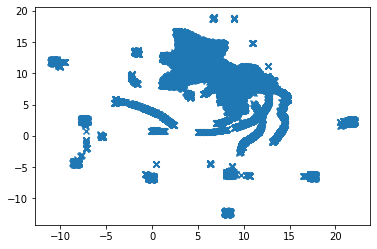

In [40]:
plt.scatter(embedding[:, 0], embedding[:, 1], marker="x")

In [41]:
embedding

array([[ 8.288635 , 10.501492 ],
       [ 8.50032  , 10.352903 ],
       [ 8.545265 , 10.540835 ],
       ...,
       [ 8.644388 , 10.424241 ],
       [ 8.538296 , 10.615389 ],
       [ 8.57214  , 10.6136055]], dtype=float32)